In [22]:
import pandas as pd
from bs4 import BeautifulSoup
import requests
import concurrent.futures
from IPython.display import Image

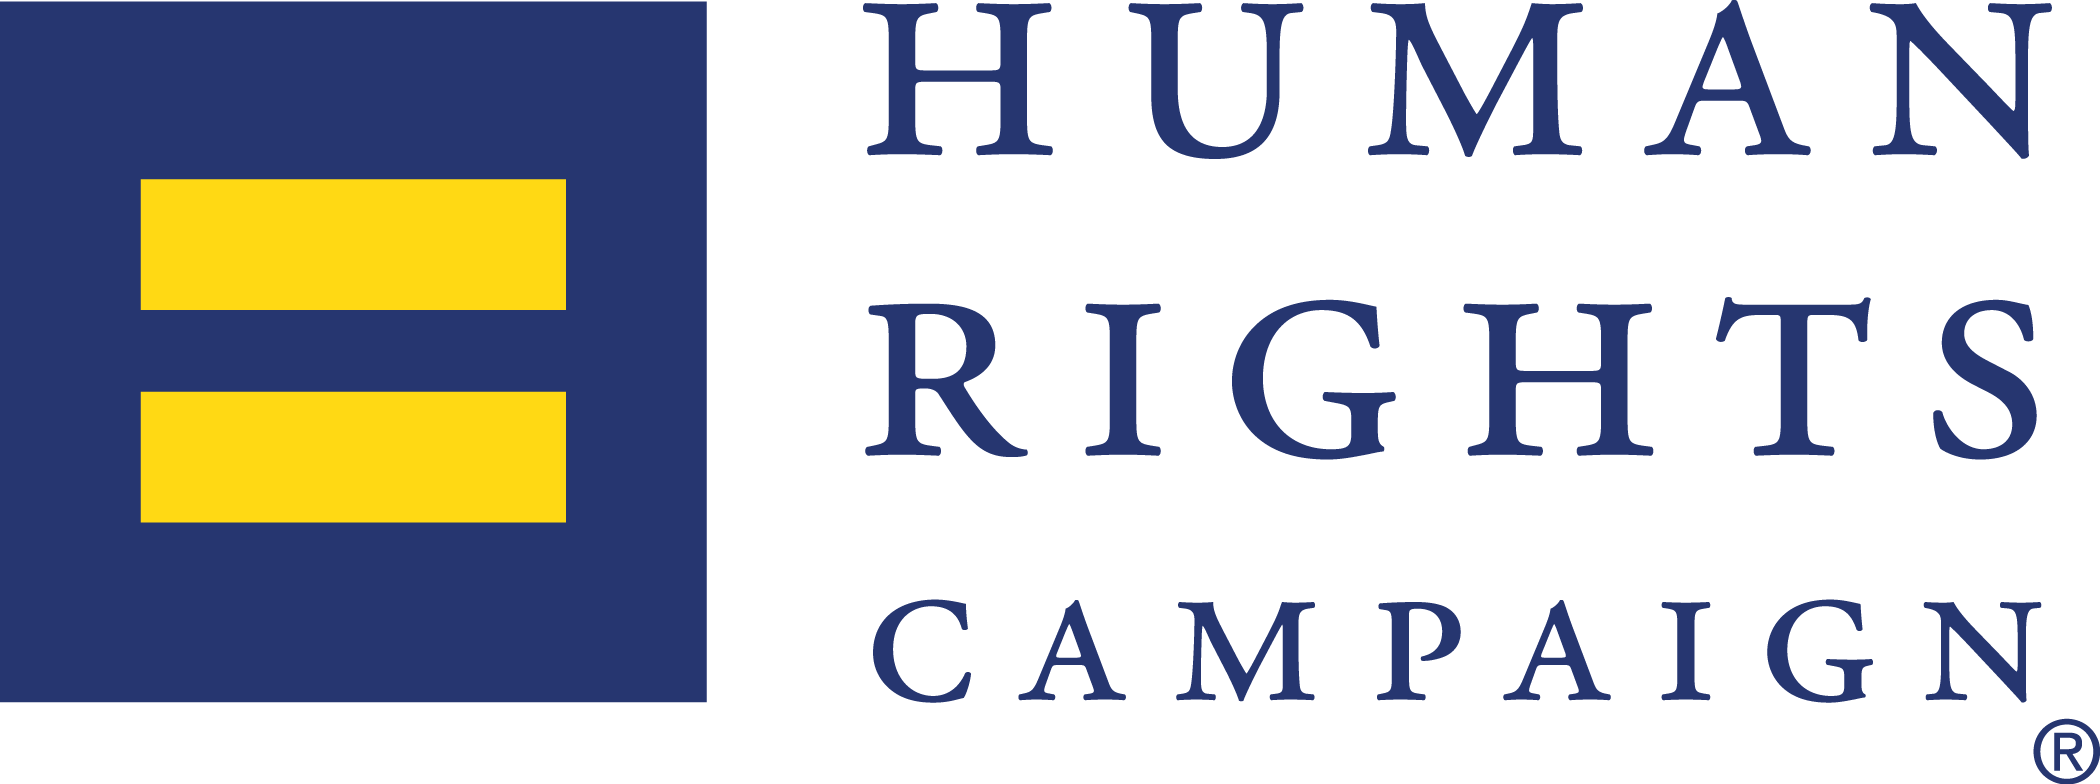

In [26]:
Image(filename='images/logo.png') 

In [2]:
#url inicial
url = 'https://www.hrc.org/resources/employers/search?q='

In [3]:
req = requests.get(url)

In [6]:
req.status_code

200

In [ ]:
# Ao acessar a listagem de empresas, podemos perceber que o site permite que a gente altere a URL e veja os resultados a partir do parametro p<numero da página> , fazendo com que nosso trabalho fique muito mais fácil

In [3]:
def  checa_pagina(num_pagina):
    '''
    Checa se existem dados disponíveis para extração na url do site HRC 
    
    uso:
        Passe o parâmetro 'num_pagina' com um número inteiro positivo .
    
    retorno:
        A função retorna os resultados como True/False
        
        True : Encontramos dados nessa página indicada
        False : Não existem dados nessa página indicada
    
    '''
    
    from bs4 import BeautifulSoup
    import requests
    
    req = requests.get(f'https://www.hrc.org/resources/employers/search/p{num_pagina}?q&sort=alpha')

    soup = BeautifulSoup(req.text,'html.parser')
    
    try:
        soup.find('h2',attrs={'class':'heading-24 mb-16'}).text.strip()
        return False
    except:
        return True

In [4]:
def  extract_dados_iniciais(num_pagina):
    '''
    Extrai os dados iniciais das empresas de uma página do site HRC
    
    uso:
        Passe o parâmetro 'num_pagina' com um número inteiro positivo .
    
    retorno:
        A função retorna um DataFrame Pandas com os dados iniciais de todas empresas contidos em uma página do site HRC.
        
        Nome > Nome da Empresa
        Endereço > Endereço da Empresa
        Tipo > Tipo da Empresa ( Corporation,Healthcare Provider, ...)
        URL > URL com dados detalhados da empresa, dentro do HRC
    
    '''
    
    from bs4 import BeautifulSoup
    import requests
    
    try:
        df_empresa = pd.DataFrame()
        dados_empresa = {}

        req = requests.get(f'https://www.hrc.org/resources/employers/search/p{num_pagina}?q')

        soup = BeautifulSoup(req.text, 'html.parser')
        painel = soup.findAll('div',attrs={'class':'wrapper -padded -lg'})[2]
        artigos = painel.findAll('article')

        for item in artigos:

            dados_empresa['nome'] = item.get('aria-label')

            dados_empresa['endereco'] = item.find(class_='flex flex-wrap').find_previous_sibling().text

            dados_empresa['tipo'] = item.find(class_='inline-flex items-center py-16 type-italic text-blue-400 md:self-end').find_previous_sibling().find('p').text


            dados_empresa['URL'] = item.find(class_='block text-current').get('href')

            df_empresa = pd.concat([df_empresa,pd.DataFrame([dados_empresa])], ignore_index=True)

        return df_empresa
    except:
        return f"Erro ao Extrair página > {num_pagina}"
        

In [20]:
def extracao_completa_empresa(url):
    '''
    Extrai os dados completos das empresas de uma página do site HRC
    
    uso:
        Passe o parâmetro 'url' indicando a url específica da empresa dentro do site HRC , ex: https://www.hrc.org/resources/buyers-guide/zoom-video-communications-inc.
    
    retorno:
        A função retorna um DataFrame Pandas com os dados específicos da empresa.

        Company Name
        Company Headquartes
        Company Address
        Company Brands
        Company URL
        Company Score
        criteria_x
        criteria_points_x
        criteria_number_x
        sub_crit_x_x
        detailed_rating_x_x
        criteria_number_x_x
    
        O número de colunas varia dependendo da quantidade de critérios que a empresa possui.
    
    '''
    
    
    
    import requests
    import pandas as pd
    from bs4 import BeautifulSoup
        
    
    req = requests.get(url)
    
    soup = BeautifulSoup(req.text,'html.parser')
    
    nome_empresa = soup.find('h1',attrs={'class':'heading-60 mb-32 relative z-1'}).text.strip()
    
    try:
        score = soup.find(class_='bg-yellow-500 heading-48 p-16 text-black text-center w-full md:p-32').text.strip().split('\n')[0]
    except:
        score = ''
    
    headquarters = soup.find(string='Headquarters').find_next().text.strip()
    
    address = ' '.join(soup.find(string='Address').find_next().text.split('Map')[0].strip().replace('\n','').split())
    
    try:
        marcas = []
        for i in soup.find(string='Brands').find_next().findAll('span'):
            marcas.append(i.text.strip())
    except:
        marcas = ''
        
    url = soup.find(string='Contact').find_next('a').get('href')
    
    
    df_inicial = pd.DataFrame([[nome_empresa,headquarters,address,marcas,url,score]])
    
    df_inicial = df_inicial.rename(columns={0:'Company Name',1:'Company Headquartes',2:'Company Address',3:'Company Brands',4:'Company URL',5:'Company Score'})
    
    
    layout = soup.findAll(class_='wrapper -padded -lg')[2]
    
    
    criteria_dict = {}
    criteria_df = pd.DataFrame()
    num = 1
    for i in layout.findAll(class_='bg-blue-100 p-24 lg:p-32'):

        criteria_dict['criteria_{}'.format(num)] = i.find('h2',attrs={'class':'heading-32'}).text.strip()

        criteria_dict['criteria_points_{}'.format(num)] = i.find('div',attrs={'class':'text-right'}).find(class_='heading-32').text.strip()

        criteria_dict['criteria_number_{}'.format(num)] = num
        
        criteria_df = pd.concat([criteria_df,pd.DataFrame([criteria_dict])], ignore_index=True)
        

        num+=1
    
    
   
    num = 1
    subcriteria_dict = {}

    subcriteria_df = pd.DataFrame()
    for i in layout.findAll(class_='bg-white p-24 lg:p-32'):
        
        num_in = 1
        for sub in i.findAll(class_='flex leading-tight pr-16 text-14 md:pr-24'):
            
            if sub.find('svg').find('path').get('d') == 'M36.2001 0.400098C16.3001 0.400098 0.200049 16.5001 0.200049 36.4001C0.200049 56.3001 16.3001 72.4001 36.2001 72.4001C56.1001 72.4001 72.2001 56.3001 72.2001 36.4001C72.2001 16.5001 56.1001 0.400098 36.2001 0.400098ZM59.2001 26.9001L33.9001 52.2001C33.2001 52.9001 31.7 53.5001 30.7 53.5001H28.5001C27.5001 53.5001 26 52.9001 25.3 52.2001L13.4001 40.2001C12.7001 39.5001 12.7001 38.3001 13.4001 37.5001L18.1001 32.8001C18.8001 32.1001 20 32.1001 20.8 32.8001L28.4001 40.4001C29.1001 41.1001 30.3001 41.1001 31.0001 40.4001L51.8 19.5001C52.5 18.8001 53.7001 18.8001 54.5001 19.5001L59.2001 24.1001C59.9001 25.0001 59.9001 26.2001 59.2001 26.9001Z':
                detailed_rating = 'Yes'
            elif sub.find('svg').find('path').get('d') == 'M36.2001 0.400098C16.3001 0.400098 0.200049 16.5001 0.200049 36.4001C0.200049 56.3001 16.3001 72.4001 36.2001 72.4001C56.1001 72.4001 72.2001 56.3001 72.2001 36.4001C72.2001 16.5001 56.1001 0.400098 36.2001 0.400098ZM36.2001 63.4001C21.3001 63.4001 9.20005 51.3001 9.20005 36.4001C9.20005 21.5001 21.3001 9.4001 36.2001 9.4001C51.1001 9.4001 63.2001 21.5001 63.2001 36.4001C63.2001 51.3001 51.1001 63.4001 36.2001 63.4001Z':
                detailed_rating = 'No'
            elif sub.find('svg').find('path').get('d') == 'M36.8997 0.700073C16.9997 0.700073 0.899707 16.8001 0.899707 36.7001C0.899707 56.6001 16.9997 72.7001 36.8997 72.7001C56.7997 72.7001 72.8997 56.6001 72.8997 36.7001C72.8997 16.9001 56.7997 0.700073 36.8997 0.700073ZM6.89971 36.7001C6.89971 20.2001 20.3997 6.70007 36.8997 6.70007V66.7001C20.2997 66.7001 6.89971 53.3001 6.89971 36.7001Z':
                detailed_rating = 'Partial'
            elif sub.find('svg').find('path').get('d') == 'M36.2001 0.400098C16.3001 0.400098 0.200049 16.5001 0.200049 36.4001C0.200049 56.3001 16.3001 72.4001 36.2001 72.4001C56.1001 72.4001 72.2001 56.3001 72.2001 36.4001C72.2001 16.5001 56.1001 0.400098 36.2001 0.400098ZM38.6001 57.9001C37.5001 58.9001 36.1001 59.4001 34.4001 59.4001C32.8001 59.4001 31.4001 58.9001 30.4001 57.9001C29.3001 56.9001 28.8 55.5001 28.8 53.9001C28.8 52.3001 29.3001 50.9001 30.4001 49.9001C31.5001 48.9001 32.9001 48.4001 34.5001 48.4001C36.2001 48.4001 37.6001 48.9001 38.7001 49.9001C39.8 50.9001 40.3 52.3001 40.3 53.9001C40.2 55.5001 39.7001 56.9001 38.6001 57.9001ZM48.2001 30.4001C47.6001 31.8001 46.9001 33.0001 46.1001 34.0001C45.3001 35.0001 44.4001 35.8001 43.4001 36.6001C42.5001 37.3001 41.7001 38.0001 40.9001 38.7001C40.2001 39.4001 39.6001 40.3001 39.1001 41.3001C38.6001 42.2001 38.4001 43.3001 38.4001 44.9001V45.9001H30.9001H30.0001L29.9001 45.0001C29.8001 44.3001 29.8 43.6001 29.8 43.0001C29.8 41.7001 29.9 40.5001 30.2 39.5001C30.6 38.0001 31.2001 36.7001 31.9001 35.5001C32.6001 34.4001 33.5001 33.4001 34.4001 32.6001C35.3001 31.8001 36.1 31.1001 36.8 30.4001C37.5 29.7001 38.1001 29.1001 38.6001 28.4001C39.0001 27.8001 39.2001 27.1001 39.2001 26.2001C39.2001 25.0001 38.9 24.2001 38.3 23.6001C37.9 23.1001 36.8001 22.7001 35.0001 22.7001C34.4001 22.7001 33.8 22.8001 33.2001 22.9001C32.5 23.0001 31.9 23.2001 31.2 23.4001C30.5 23.6001 29.9 23.9001 29.3 24.2001C28.7 24.5001 28.1 24.8001 27.7 25.2001L26.8 25.8001L22.9001 18.4001L23.6001 17.9001C25.2001 16.8001 27.0001 15.9001 29.0001 15.3001C31.1001 14.6001 33.5 14.3001 36.3 14.3001C40.1 14.3001 43.3001 15.2001 45.6001 17.2001C47.9001 19.2001 49.1001 21.9001 49.1001 25.1001C49.1001 27.1001 48.8 28.9001 48.2001 30.4001Z':
                detailed_rating = 'No Data'
            elif sub.find('svg').find('path').get('d') == 'M36.2003 0.400098C16.3003 0.400098 0.200293 16.5001 0.200293 36.4001C0.200293 56.3001 16.3003 72.4001 36.2003 72.4001C56.1003 72.4001 72.2003 56.3001 72.2003 36.4001C72.2003 16.5001 56.1003 0.400098 36.2003 0.400098ZM63.2003 36.4001C63.2003 42.2001 61.3003 47.6001 58.2003 52.0001L20.6002 14.4001C25.0002 11.3001 30.4003 9.4001 36.2003 9.4001C51.1003 9.4001 63.2003 21.5001 63.2003 36.4001ZM9.20029 36.4001C9.20029 30.5001 11.1001 25.1001 14.3001 20.7001L51.9002 58.3001C47.5002 61.5001 42.0003 63.4001 36.2003 63.4001C21.3003 63.4001 9.20029 51.3001 9.20029 36.4001Z':
                detailed_rating = 'Not Applicable'

            sub_crit = sub.text.strip().split(':')[1].strip()

            subcriteria_dict['sub_crit_{}_{}'.format(num,num_in)] = sub_crit

            subcriteria_dict['detailed_rating_{}_{}'.format(num,num_in)] = detailed_rating

            subcriteria_dict['criteria_number_{}_{}'.format(num,num_in)] = num

            subcriteria_df = pd.concat([subcriteria_df,pd.DataFrame([subcriteria_dict])], ignore_index=True)
            
            num_in+=1
            
        num+=1

        
    subcriteria_df = subcriteria_df.tail(1)
    criteria_df = criteria_df.tail(1)
    
    lista2 =subcriteria_df.columns.tolist()
    
    lista1 =criteria_df.columns.tolist()
    
    cols = [x for x in lista2 if x not in lista1]
    
    subcriteria_df = subcriteria_df.reset_index(drop=True)
    
    criteria_df = criteria_df.reset_index(drop=True)
    
    
    subcriteria_df = subcriteria_df[cols]

    try:
        part1 = pd.merge(criteria_df,subcriteria_df,how='left', left_index=True,right_index=True)
        return pd.merge(df_inicial,part1,how='cross')
    
    except Exception as E:
        print(E)
        
        return pd.merge(df_inicial,criteria_df,how='cross')
    
   
    
    
    

In [29]:
#lógica para descobrir quantidade total de páginas a serem capturadas


num_pagina = 395


while True:

    check = checa_pagina(num_pagina)
    
    num_pagina+=1
    
    print(check , num_pagina)
    
    if check == False:
        num_max_pagina = num_pagina -1
        print('Não tem dados', check , num_pagina)
        break



True 396
True 397
True 398
True 399
True 400
True 401
True 402
True 403
True 404
True 405
True 406
True 407
True 408
True 409
True 410
True 411
True 412
True 413
True 414
True 415
True 416
False 417
Não tem dados False 417


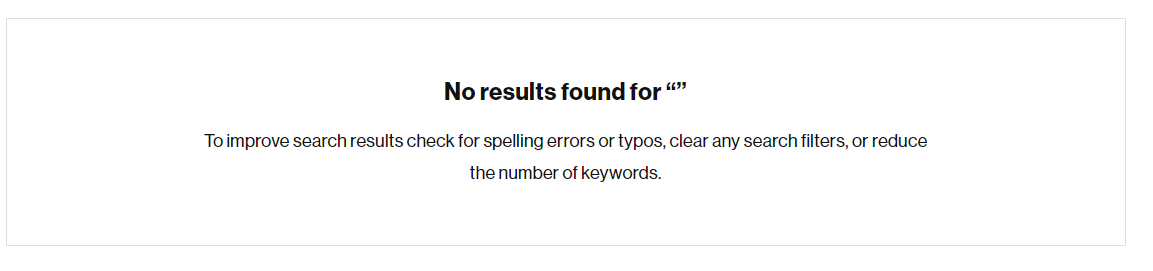

In [23]:
# O site exibe uma mensagem de erro quando não localiza os dados de uma determinada página informada


Image(filename='images/no_data_result.png') 

In [6]:
num_max_pagina = 416

In [7]:
# temos mais de 400 páginas para extrair, portanto, vamos paralelizar a extração dos dados iniciais.

# ATENÇÃO , use o parâmetro max_workers com MUITA cautela. Isso pode ser prejudicial para o Servidor (Site que estamos extraindo) e para o seu próprio Host (uso massivo de hardware)

df_init = pd.DataFrame()

with concurrent.futures.ThreadPoolExecutor(max_workers=8) as executor:
    future_to_url= (executor.submit(extract_dados_iniciais,pagina) for pagina in range(1,num_max_pagina))

    for cont,future in enumerate(concurrent.futures.as_completed(future_to_url)):
    
        df_in = pd.DataFrame(future.result())

        df_init = pd.concat([df_in, df_init],ignore_index=True)


        print("Extraindo página > ",cont+1,"de ",num_max_pagina)




Extraindo página >  1 de  416
Extraindo página >  2 de  416
Extraindo página >  3 de  416
Extraindo página >  4 de  416
Extraindo página >  5 de  416
Extraindo página >  6 de  416
Extraindo página >  7 de  416
Extraindo página >  8 de  416
Extraindo página >  9 de  416
Extraindo página >  10 de  416
Extraindo página >  11 de  416
Extraindo página >  12 de  416
Extraindo página >  13 de  416
Extraindo página >  14 de  416
Extraindo página >  15 de  416
Extraindo página >  16 de  416
Extraindo página >  17 de  416
Extraindo página >  18 de  416
Extraindo página >  19 de  416
Extraindo página >  20 de  416
Extraindo página >  21 de  416
Extraindo página >  22 de  416
Extraindo página >  23 de  416
Extraindo página >  24 de  416
Extraindo página >  25 de  416
Extraindo página >  26 de  416
Extraindo página >  27 de  416
Extraindo página >  28 de  416
Extraindo página >  29 de  416
Extraindo página >  30 de  416
Extraindo página >  31 de  416
Extraindo página >  32 de  416
Extraindo página 

Extraindo página >  262 de  416
Extraindo página >  263 de  416
Extraindo página >  264 de  416
Extraindo página >  265 de  416
Extraindo página >  266 de  416
Extraindo página >  267 de  416
Extraindo página >  268 de  416
Extraindo página >  269 de  416
Extraindo página >  270 de  416
Extraindo página >  271 de  416
Extraindo página >  272 de  416
Extraindo página >  273 de  416
Extraindo página >  274 de  416
Extraindo página >  275 de  416
Extraindo página >  276 de  416
Extraindo página >  277 de  416
Extraindo página >  278 de  416
Extraindo página >  279 de  416
Extraindo página >  280 de  416
Extraindo página >  281 de  416
Extraindo página >  282 de  416
Extraindo página >  283 de  416
Extraindo página >  284 de  416
Extraindo página >  285 de  416
Extraindo página >  286 de  416
Extraindo página >  287 de  416
Extraindo página >  288 de  416
Extraindo página >  289 de  416
Extraindo página >  290 de  416
Extraindo página >  291 de  416
Extraindo página >  292 de  416
Extraind

In [13]:
df_init.to_parquet("df_inicial")

In [8]:
#Separando todas urls que iremos extrair
urls_empresas = df_init['URL'].unique().tolist()

In [9]:
len(urls_empresas)

4148

In [17]:
# temos mais de 4000 empresas para extrair, portanto, vamos paralelizar a extração dos dados iniciais.

# ATENÇÃO , use o parâmetro max_workers com MUITA cautela. Isso pode ser prejudicial para o Servidor (Site que estamos extraindo) e para o seu próprio Host (uso massivo de hardware)

df_empresas = pd.DataFrame()

with concurrent.futures.ThreadPoolExecutor(max_workers=8) as executor:
    future_to_url= (executor.submit(extracao_completa_empresa,url) for url in urls_empresas)

    for cont,future in enumerate(concurrent.futures.as_completed(future_to_url)):
    
        try:
            df_in = pd.DataFrame(future.result())

            df_empresas = pd.concat([df_in, df_empresas],ignore_index=True)
        except:
            pass


        print("Extraindo página > ",cont+1,"de ",len(urls_empresas))




Extraindo página >  1 de  4148
Extraindo página >  2 de  4148
Extraindo página >  3 de  4148
Extraindo página >  4 de  4148
Extraindo página >  5 de  4148
Extraindo página >  6 de  4148
Extraindo página >  7 de  4148
Extraindo página >  8 de  4148
Extraindo página >  9 de  4148
Extraindo página >  10 de  4148
Extraindo página >  11 de  4148
Extraindo página >  12 de  4148
Extraindo página >  13 de  4148
Extraindo página >  14 de  4148
Extraindo página >  15 de  4148
Extraindo página >  16 de  4148
Extraindo página >  17 de  4148
Extraindo página >  18 de  4148
Extraindo página >  19 de  4148
Extraindo página >  20 de  4148
Extraindo página >  21 de  4148
Extraindo página >  22 de  4148
Extraindo página >  23 de  4148
Extraindo página >  24 de  4148
Extraindo página >  25 de  4148
Extraindo página >  26 de  4148
Extraindo página >  27 de  4148
Extraindo página >  28 de  4148
Extraindo página >  29 de  4148
Extraindo página >  30 de  4148
Extraindo página >  31 de  4148
Extraindo página 

Extraindo página >  257 de  4148
Extraindo página >  258 de  4148
Extraindo página >  259 de  4148
Extraindo página >  260 de  4148
Extraindo página >  261 de  4148
Extraindo página >  262 de  4148
Extraindo página >  263 de  4148
Extraindo página >  264 de  4148
Extraindo página >  265 de  4148
Extraindo página >  266 de  4148
Extraindo página >  267 de  4148
Extraindo página >  268 de  4148
Extraindo página >  269 de  4148
Extraindo página >  270 de  4148
Extraindo página >  271 de  4148
Extraindo página >  272 de  4148
Extraindo página >  273 de  4148
Extraindo página >  274 de  4148
Extraindo página >  275 de  4148
Extraindo página >  276 de  4148
Extraindo página >  277 de  4148
Extraindo página >  278 de  4148
Extraindo página >  279 de  4148
Extraindo página >  280 de  4148
Extraindo página >  281 de  4148
Extraindo página >  282 de  4148
Extraindo página >  283 de  4148
Extraindo página >  284 de  4148
Extraindo página >  285 de  4148
Extraindo página >  286 de  4148
Extraindo 

Extraindo página >  508 de  4148
Extraindo página >  509 de  4148
Extraindo página >  510 de  4148
Extraindo página >  511 de  4148
Extraindo página >  512 de  4148
Extraindo página >  513 de  4148
Extraindo página >  514 de  4148
Extraindo página >  515 de  4148
Extraindo página >  516 de  4148
Extraindo página >  517 de  4148
Extraindo página >  518 de  4148
Extraindo página >  519 de  4148
Extraindo página >  520 de  4148
Extraindo página >  521 de  4148
Extraindo página >  522 de  4148
Extraindo página >  523 de  4148
Extraindo página >  524 de  4148
Extraindo página >  525 de  4148
Extraindo página >  526 de  4148
Extraindo página >  527 de  4148
Extraindo página >  528 de  4148
Extraindo página >  529 de  4148
Extraindo página >  530 de  4148
Extraindo página >  531 de  4148
Extraindo página >  532 de  4148
Extraindo página >  533 de  4148
Extraindo página >  534 de  4148
Extraindo página >  535 de  4148
Extraindo página >  536 de  4148
Extraindo página >  537 de  4148
Extraindo 

Extraindo página >  757 de  4148
Extraindo página >  758 de  4148
Extraindo página >  759 de  4148
Extraindo página >  760 de  4148
Extraindo página >  761 de  4148
Extraindo página >  762 de  4148
Extraindo página >  763 de  4148
Extraindo página >  764 de  4148
Extraindo página >  765 de  4148
Extraindo página >  766 de  4148
Extraindo página >  767 de  4148
Extraindo página >  768 de  4148
Extraindo página >  769 de  4148
Extraindo página >  770 de  4148
Extraindo página >  771 de  4148
Extraindo página >  772 de  4148
Extraindo página >  773 de  4148
Extraindo página >  774 de  4148
Extraindo página >  775 de  4148
Extraindo página >  776 de  4148
Extraindo página >  777 de  4148
Extraindo página >  778 de  4148
Extraindo página >  779 de  4148
Extraindo página >  780 de  4148
Extraindo página >  781 de  4148
Extraindo página >  782 de  4148
Extraindo página >  783 de  4148
Extraindo página >  784 de  4148
Extraindo página >  785 de  4148
Extraindo página >  786 de  4148
Extraindo 

Extraindo página >  1006 de  4148
Extraindo página >  1007 de  4148
Extraindo página >  1008 de  4148
Extraindo página >  1009 de  4148
Extraindo página >  1010 de  4148
Extraindo página >  1011 de  4148
Extraindo página >  1012 de  4148
Extraindo página >  1013 de  4148
Extraindo página >  1014 de  4148
Extraindo página >  1015 de  4148
Extraindo página >  1016 de  4148
Extraindo página >  1017 de  4148
Extraindo página >  1018 de  4148
Extraindo página >  1019 de  4148
Extraindo página >  1020 de  4148
Extraindo página >  1021 de  4148
Extraindo página >  1022 de  4148
Extraindo página >  1023 de  4148
Extraindo página >  1024 de  4148
Extraindo página >  1025 de  4148
Extraindo página >  1026 de  4148
Extraindo página >  1027 de  4148
Extraindo página >  1028 de  4148
Extraindo página >  1029 de  4148
Extraindo página >  1030 de  4148
Extraindo página >  1031 de  4148
Extraindo página >  1032 de  4148
Extraindo página >  1033 de  4148
Extraindo página >  1034 de  4148
Extraindo pági

Extraindo página >  1247 de  4148
Extraindo página >  1248 de  4148
Extraindo página >  1249 de  4148
Extraindo página >  1250 de  4148
Extraindo página >  1251 de  4148
Extraindo página >  1252 de  4148
Extraindo página >  1253 de  4148
Extraindo página >  1254 de  4148
Extraindo página >  1255 de  4148
Extraindo página >  1256 de  4148
Extraindo página >  1257 de  4148
Extraindo página >  1258 de  4148
Extraindo página >  1259 de  4148
Extraindo página >  1260 de  4148
Extraindo página >  1261 de  4148
Extraindo página >  1262 de  4148
Extraindo página >  1263 de  4148
Extraindo página >  1264 de  4148
Extraindo página >  1265 de  4148
Extraindo página >  1266 de  4148
Extraindo página >  1267 de  4148
Extraindo página >  1268 de  4148
Extraindo página >  1269 de  4148
Extraindo página >  1270 de  4148
Extraindo página >  1271 de  4148
Extraindo página >  1272 de  4148
Extraindo página >  1273 de  4148
Extraindo página >  1274 de  4148
Extraindo página >  1275 de  4148
Extraindo pági

Extraindo página >  1488 de  4148
Extraindo página >  1489 de  4148
Extraindo página >  1490 de  4148
Extraindo página >  1491 de  4148
Extraindo página >  1492 de  4148
Extraindo página >  1493 de  4148
Extraindo página >  1494 de  4148
Extraindo página >  1495 de  4148
Extraindo página >  1496 de  4148
Extraindo página >  1497 de  4148
Extraindo página >  1498 de  4148
Extraindo página >  1499 de  4148
Extraindo página >  1500 de  4148
Extraindo página >  1501 de  4148
Extraindo página >  1502 de  4148
Extraindo página >  1503 de  4148
Extraindo página >  1504 de  4148
Extraindo página >  1505 de  4148
Extraindo página >  1506 de  4148
Extraindo página >  1507 de  4148
Extraindo página >  1508 de  4148
Extraindo página >  1509 de  4148
Extraindo página >  1510 de  4148
Extraindo página >  1511 de  4148
Extraindo página >  1512 de  4148
Extraindo página >  1513 de  4148
Extraindo página >  1514 de  4148
Extraindo página >  1515 de  4148
Extraindo página >  1516 de  4148
Extraindo pági

Extraindo página >  1729 de  4148
Extraindo página >  1730 de  4148
Extraindo página >  1731 de  4148
Extraindo página >  1732 de  4148
Extraindo página >  1733 de  4148
Extraindo página >  1734 de  4148
Extraindo página >  1735 de  4148
Extraindo página >  1736 de  4148
Extraindo página >  1737 de  4148
Extraindo página >  1738 de  4148
Extraindo página >  1739 de  4148
Extraindo página >  1740 de  4148
Extraindo página >  1741 de  4148
Extraindo página >  1742 de  4148
Extraindo página >  1743 de  4148
Extraindo página >  1744 de  4148
Extraindo página >  1745 de  4148
Extraindo página >  1746 de  4148
Extraindo página >  1747 de  4148
Extraindo página >  1748 de  4148
Extraindo página >  1749 de  4148
Extraindo página >  1750 de  4148
Extraindo página >  1751 de  4148
Extraindo página >  1752 de  4148
Extraindo página >  1753 de  4148
Extraindo página >  1754 de  4148
Extraindo página >  1755 de  4148
Extraindo página >  1756 de  4148
Extraindo página >  1757 de  4148
Extraindo pági

Extraindo página >  1970 de  4148
Extraindo página >  1971 de  4148
Extraindo página >  1972 de  4148
Extraindo página >  1973 de  4148
Extraindo página >  1974 de  4148
Extraindo página >  1975 de  4148
Extraindo página >  1976 de  4148
Extraindo página >  1977 de  4148
Extraindo página >  1978 de  4148
Extraindo página >  1979 de  4148
Extraindo página >  1980 de  4148
Extraindo página >  1981 de  4148
Extraindo página >  1982 de  4148
Extraindo página >  1983 de  4148
Extraindo página >  1984 de  4148
Extraindo página >  1985 de  4148
Extraindo página >  1986 de  4148
Extraindo página >  1987 de  4148
Extraindo página >  1988 de  4148
Extraindo página >  1989 de  4148
Extraindo página >  1990 de  4148
Extraindo página >  1991 de  4148
Extraindo página >  1992 de  4148
Extraindo página >  1993 de  4148
Extraindo página >  1994 de  4148
Extraindo página >  1995 de  4148
Extraindo página >  1996 de  4148
Extraindo página >  1997 de  4148
Extraindo página >  1998 de  4148
Extraindo pági

Extraindo página >  2211 de  4148
Extraindo página >  2212 de  4148
Extraindo página >  2213 de  4148
Extraindo página >  2214 de  4148
Extraindo página >  2215 de  4148
Extraindo página >  2216 de  4148
Extraindo página >  2217 de  4148
Extraindo página >  2218 de  4148
Extraindo página >  2219 de  4148
Extraindo página >  2220 de  4148
Extraindo página >  2221 de  4148
Extraindo página >  2222 de  4148
Extraindo página >  2223 de  4148
Extraindo página >  2224 de  4148
Extraindo página >  2225 de  4148
Extraindo página >  2226 de  4148
Extraindo página >  2227 de  4148
Extraindo página >  2228 de  4148
Extraindo página >  2229 de  4148
Extraindo página >  2230 de  4148
Extraindo página >  2231 de  4148
Extraindo página >  2232 de  4148
Extraindo página >  2233 de  4148
Extraindo página >  2234 de  4148
Extraindo página >  2235 de  4148
Extraindo página >  2236 de  4148
Extraindo página >  2237 de  4148
Extraindo página >  2238 de  4148
Extraindo página >  2239 de  4148
Extraindo pági

Extraindo página >  2454 de  4148
Extraindo página >  2455 de  4148
Extraindo página >  2456 de  4148
Extraindo página >  2457 de  4148
Extraindo página >  2458 de  4148
Extraindo página >  2459 de  4148
Extraindo página >  2460 de  4148
Extraindo página >  2461 de  4148
Extraindo página >  2462 de  4148
Extraindo página >  2463 de  4148
Extraindo página >  2464 de  4148
Extraindo página >  2465 de  4148
Extraindo página >  2466 de  4148
Extraindo página >  2467 de  4148
Extraindo página >  2468 de  4148
Extraindo página >  2469 de  4148
Extraindo página >  2470 de  4148
Extraindo página >  2471 de  4148
Extraindo página >  2472 de  4148
Extraindo página >  2473 de  4148
Extraindo página >  2474 de  4148
Extraindo página >  2475 de  4148
Extraindo página >  2476 de  4148
Extraindo página >  2477 de  4148
Extraindo página >  2478 de  4148
Extraindo página >  2479 de  4148
Extraindo página >  2480 de  4148
Extraindo página >  2481 de  4148
Extraindo página >  2482 de  4148
Extraindo pági

Extraindo página >  2698 de  4148
Extraindo página >  2699 de  4148
Extraindo página >  2700 de  4148
Extraindo página >  2701 de  4148
Extraindo página >  2702 de  4148
Extraindo página >  2703 de  4148
Extraindo página >  2704 de  4148
Extraindo página >  2705 de  4148
Extraindo página >  2706 de  4148
Extraindo página >  2707 de  4148
Extraindo página >  2708 de  4148
Extraindo página >  2709 de  4148
Extraindo página >  2710 de  4148
Extraindo página >  2711 de  4148
Extraindo página >  2712 de  4148
Extraindo página >  2713 de  4148
Extraindo página >  2714 de  4148
Extraindo página >  2715 de  4148
Extraindo página >  2716 de  4148
Extraindo página >  2717 de  4148
Extraindo página >  2718 de  4148
Extraindo página >  2719 de  4148
Extraindo página >  2720 de  4148
Extraindo página >  2721 de  4148
Extraindo página >  2722 de  4148
Extraindo página >  2723 de  4148
Extraindo página >  2724 de  4148
Extraindo página >  2725 de  4148
Extraindo página >  2726 de  4148
Extraindo pági

Extraindo página >  2942 de  4148
Extraindo página >  2943 de  4148
Extraindo página >  2944 de  4148
Extraindo página >  2945 de  4148
Extraindo página >  2946 de  4148
Extraindo página >  2947 de  4148
Extraindo página >  2948 de  4148
Extraindo página >  2949 de  4148
Extraindo página >  2950 de  4148
Extraindo página >  2951 de  4148
Extraindo página >  2952 de  4148
Extraindo página >  2953 de  4148
Extraindo página >  2954 de  4148
Extraindo página >  2955 de  4148
Extraindo página >  2956 de  4148
Extraindo página >  2957 de  4148
Extraindo página >  2958 de  4148
Extraindo página >  2959 de  4148
Extraindo página >  2960 de  4148
Extraindo página >  2961 de  4148
Extraindo página >  2962 de  4148
Extraindo página >  2963 de  4148
Extraindo página >  2964 de  4148
Extraindo página >  2965 de  4148
Extraindo página >  2966 de  4148
Extraindo página >  2967 de  4148
Extraindo página >  2968 de  4148
Extraindo página >  2969 de  4148
Extraindo página >  2970 de  4148
Extraindo pági

Extraindo página >  3186 de  4148
Extraindo página >  3187 de  4148
Extraindo página >  3188 de  4148
Extraindo página >  3189 de  4148
Extraindo página >  3190 de  4148
Extraindo página >  3191 de  4148
Extraindo página >  3192 de  4148
Extraindo página >  3193 de  4148
Extraindo página >  3194 de  4148
Extraindo página >  3195 de  4148
Extraindo página >  3196 de  4148
Extraindo página >  3197 de  4148
Extraindo página >  3198 de  4148
Extraindo página >  3199 de  4148
Extraindo página >  3200 de  4148
Extraindo página >  3201 de  4148
Extraindo página >  3202 de  4148
Extraindo página >  3203 de  4148
Extraindo página >  3204 de  4148
Extraindo página >  3205 de  4148
Extraindo página >  3206 de  4148
Extraindo página >  3207 de  4148
Extraindo página >  3208 de  4148
Extraindo página >  3209 de  4148
Extraindo página >  3210 de  4148
Extraindo página >  3211 de  4148
Extraindo página >  3212 de  4148
Extraindo página >  3213 de  4148
Extraindo página >  3214 de  4148
Extraindo pági

Extraindo página >  3427 de  4148
Extraindo página >  3428 de  4148
Extraindo página >  3429 de  4148
Extraindo página >  3430 de  4148
Extraindo página >  3431 de  4148
Extraindo página >  3432 de  4148
Extraindo página >  3433 de  4148
Extraindo página >  3434 de  4148
Extraindo página >  3435 de  4148
Extraindo página >  3436 de  4148
Extraindo página >  3437 de  4148
Extraindo página >  3438 de  4148
Extraindo página >  3439 de  4148
Extraindo página >  3440 de  4148
Extraindo página >  3441 de  4148
Extraindo página >  3442 de  4148
Extraindo página >  3443 de  4148
Extraindo página >  3444 de  4148
Extraindo página >  3445 de  4148
Extraindo página >  3446 de  4148
Extraindo página >  3447 de  4148
Extraindo página >  3448 de  4148
Extraindo página >  3449 de  4148
Extraindo página >  3450 de  4148
Extraindo página >  3451 de  4148
Extraindo página >  3452 de  4148
Extraindo página >  3453 de  4148
Extraindo página >  3454 de  4148
Extraindo página >  3455 de  4148
Extraindo pági

Extraindo página >  3669 de  4148
Extraindo página >  3670 de  4148
Extraindo página >  3671 de  4148
Extraindo página >  3672 de  4148
Extraindo página >  3673 de  4148
Extraindo página >  3674 de  4148
Extraindo página >  3675 de  4148
Extraindo página >  3676 de  4148
Extraindo página >  3677 de  4148
Extraindo página >  3678 de  4148
Extraindo página >  3679 de  4148
Extraindo página >  3680 de  4148
Extraindo página >  3681 de  4148
Extraindo página >  3682 de  4148
Extraindo página >  3683 de  4148
Extraindo página >  3684 de  4148
Extraindo página >  3685 de  4148
Extraindo página >  3686 de  4148
Extraindo página >  3687 de  4148
Extraindo página >  3688 de  4148
Extraindo página >  3689 de  4148
Extraindo página >  3690 de  4148
Extraindo página >  3691 de  4148
Extraindo página >  3692 de  4148
Extraindo página >  3693 de  4148
Extraindo página >  3694 de  4148
Extraindo página >  3695 de  4148
Extraindo página >  3696 de  4148
Extraindo página >  3697 de  4148
Extraindo pági

Extraindo página >  3910 de  4148
Extraindo página >  3911 de  4148
Extraindo página >  3912 de  4148
Extraindo página >  3913 de  4148
Extraindo página >  3914 de  4148
Extraindo página >  3915 de  4148
Extraindo página >  3916 de  4148
Extraindo página >  3917 de  4148
Extraindo página >  3918 de  4148
Extraindo página >  3919 de  4148
Extraindo página >  3920 de  4148
Extraindo página >  3921 de  4148
Extraindo página >  3922 de  4148
Extraindo página >  3923 de  4148
Extraindo página >  3924 de  4148
Extraindo página >  3925 de  4148
Extraindo página >  3926 de  4148
Extraindo página >  3927 de  4148
Extraindo página >  3928 de  4148
Extraindo página >  3929 de  4148
Extraindo página >  3930 de  4148
Extraindo página >  3931 de  4148
Extraindo página >  3932 de  4148
Extraindo página >  3933 de  4148
Extraindo página >  3934 de  4148
Extraindo página >  3935 de  4148
Extraindo página >  3936 de  4148
Extraindo página >  3937 de  4148
Extraindo página >  3938 de  4148
Extraindo pági

In [24]:
df_empresas.to_csv("dados_empresas_hrc2.csv",sep=';',index=False)